# Medium Risk: Naive Bayes baseline

## Package

In [143]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,f1_score, plot_confusion_matrix,plot_roc_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

## Load Data

In [95]:
df = pd.read_csv('../data/cleaned_train.csv')
df = df.drop('qid',axis=1)
# proportion of target
df.target.value_counts(dropna=False)

0    1225312
1      80810
Name: target, dtype: int64

In [96]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/billy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/billy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/billy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Feature Engineering

### Some Statistical Features

In [97]:
df['length']=df['question_text'].apply(len)
df['capital']=df['question_text'].apply(lambda text: sum([1 for c in text if c.isupper()]))
df['capital_to_length']=df['capital'] / df['length']
df['word_count'] = df['question_text'].str.count('\S+')
df['word_to_length'] = df['length'] / df['word_count']

In [98]:
#split train and Validation data
X_train, X_test, y_train, y_test = train_test_split(
     df.drop('target',axis=1), df['target'], test_size=0.33, random_state=2021)

In [104]:
X_train_text = X_train['question_text']
X_train_stat_feature = np.round(X_train.drop('question_text',axis=1).values,3)
X_test_text = X_test['question_text']
X_test_stat_feature = np.round(X_test.drop('question_text',axis=1).values,3)

### TF_IDF features

In [105]:
#Lokenizer with WordNet Lemma
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer =  RegexpTokenizer(r'\w+')
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in self.tokenizer.tokenize(doc)]

In [106]:
cv = CountVectorizer(stop_words=stop_words,max_features=1000,tokenizer=LemmaTokenizer())
tfidf = TfidfVectorizer(max_features=1000,stop_words=stop_words, tokenizer= LemmaTokenizer())

In [108]:
tfidf.fit(df['question_text'])
X_train_tfidf = tfidf.transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [117]:
from scipy.sparse import hstack
X_train = hstack((X_train_tfidf, X_train_stat_feature))
X_test = hstack((X_test_tfidf,X_test_stat_feature))

## Modeling

### Use tf-idf only

In [132]:
nb_classifier = MultinomialNB()
parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_search = GridSearchCV(nb_classifier, parameters,scoring='roc_auc')

In [133]:
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc')

In [134]:
print('best parameter is', grid_search.best_params_)
print('best score is', grid_search.best_score_)

best parameter is {'alpha': 10}
best score is 0.8855933836992513


In [135]:
predict_proba_test = grid_search.predict_proba(X_test_tfidf)[:,1]
predict_test = grid_search.predict(X_test_tfidf)

accuracy = accuracy_score(y_true=y_test, y_pred=predict_test)
auc = roc_auc_score(y_true=y_test,y_score=predict_proba_test)

print('accuracy on the test set: {:.3f} \nauc on the test set: {:.3f}'.format(accuracy, auc))

accuracy on the test set: 0.941 
auc on the test set: 0.885


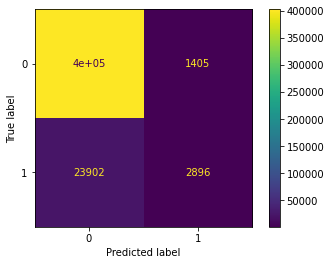

In [136]:
plot_confusion_matrix(grid_search, X_test_tfidf,y_test)

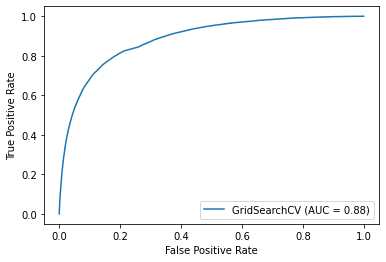

In [144]:
plot_roc_curve(grid_search,X_test_tfidf,y_test)

### add statistical features

In [137]:
nb_classifier = MultinomialNB()
parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000]}
grid_search_2 = GridSearchCV(nb_classifier, parameters,scoring='roc_auc')

In [138]:
grid_search_2.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='roc_auc')

In [129]:
print('best parameter is', grid_search_2.best_params_)
print('best score is', grid_search_2.best_score_)

best parameter is {'alpha': 0.001}
best score is 0.8887804347053935


In [140]:
predict_proba_test = grid_search_2.predict_proba(X_test)[:,1]
predict_test = grid_search_2.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=predict_test)
auc = roc_auc_score(y_true=y_test,y_score=predict_proba_test)

print('accuracy on the test set: {:.3f} \nauc on the test set: {:.3f}'.format(accuracy, auc))

accuracy on the test set: 0.940 
auc on the test set: 0.889


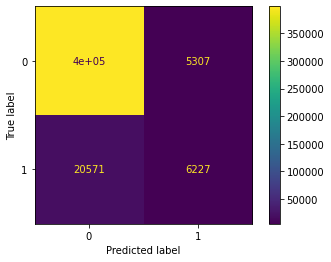

In [141]:
plot_confusion_matrix(grid_search_2, X_test,y_test)

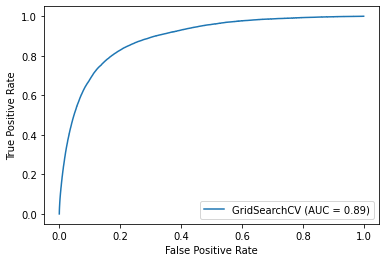

In [145]:
plot_roc_curve(grid_search_2,X_test,y_test)